In [217]:
from __future__ import print_function
import matplotlib
import os
from netCDF4 import num2date, date2num

from matplotlib.animation import FuncAnimation, writers

import pyart
import xray
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from mpl_toolkits.basemap.pyproj import Proj
from scipy.interpolate import RegularGridInterpolator
#import scipy.interpolate.griddata
%matplotlib inline

In [177]:
my_data = xray.open_mfdataset('/data/modal/wrfout_d01_2004-12-16_*', concat_dim='Time')
radar = pyart.io.read('/data/xsapr_test_case/XNW130928080000.RAW1HDW')

In [224]:
dx = my_data.DX
dy = my_data.DY
dn = -0.01

lat_0 = 18.
lon_0 = 62.
u_vel = my_data.data_vars['U']
shp = u_vel.shape
time = my_data.data_vars['Times']
lats = my_data.XLAT
lons = my_data.XLONG
levels = np.array([my_data.P.data[0, z, :, :].mean()/100.0 \
                   for z in range(my_data.P.data.shape[1])])
#y_array = np.linspace(0, (shp[2]-1)*dx,shp[2])
#x_array = np.linspace(0, (shp[3]-1)*dx,shp[3])
#n_array = np.linspace(1, (shp[1]-1)*dn,shp[1])

#fake z_array
#zero to 8km
x_array = np.linspace(-40000, 40000, shp[3])
y_array = np.linspace(-40000, 40000, shp[2])
z_array = np.linspace(8000, 0., shp[1])

0.181236 -9.33113


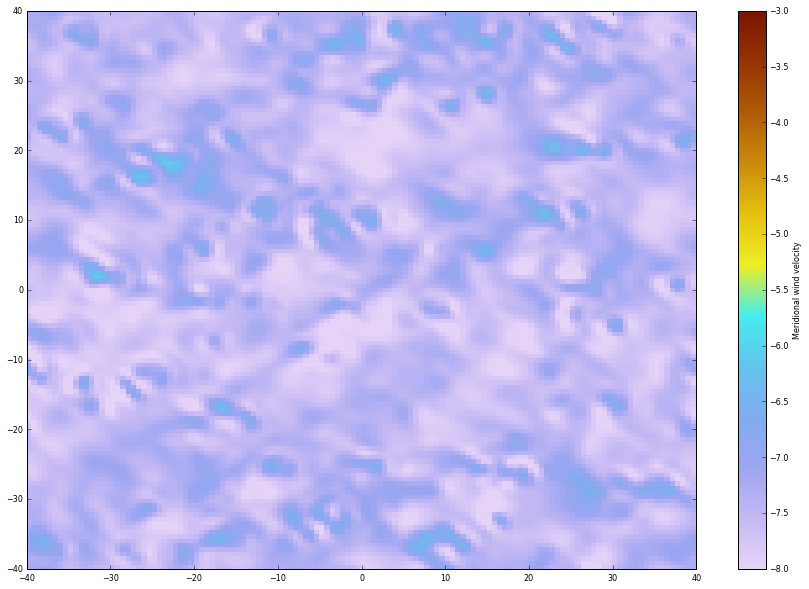

In [249]:
fig = plt.figure(figsize = [15,10])
print(u_vel.data.max(), u_vel.data.min())
plt.pcolormesh(x_array/1000.0, y_array/1000.0, 
               u_vel.data[5, 20, :,:], cmap = pyart.graph.cm.LangRainbow12,
              vmin = -8, vmax = -3)
cb = plt.colorbar()

cb.set_label('Meridional wind velocity')

<matplotlib.colorbar.Colorbar instance at 0x1180bb830>

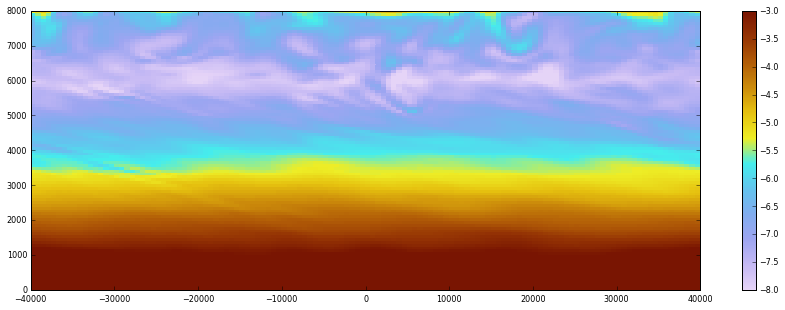

In [251]:
fig = plt.figure(figsize = [15,5])
plt.pcolormesh(x_array, z_array, u_vel.data[5, :, 110,:],
              cmap = pyart.graph.cm.LangRainbow12,
              vmin = -8, vmax = -3)
plt.colorbar()


<matplotlib.colorbar.Colorbar instance at 0x1142be998>

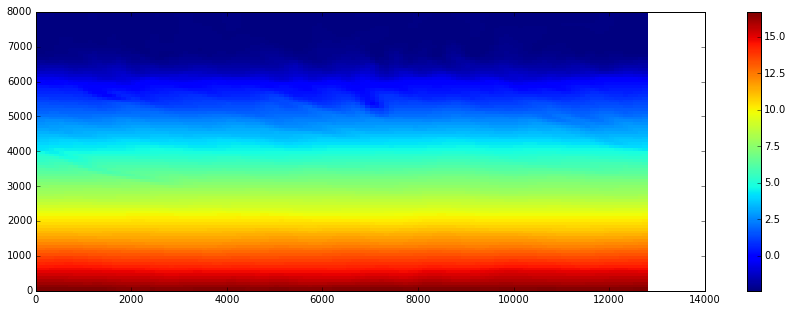

In [64]:
fig = plt.figure(figsize = [15,5])
plt.pcolormesh(x_array, z_array, my_data.variables['T'].data[5, :, 110,:])
plt.colorbar()


In [233]:
my_interpolating_function = RegularGridInterpolator((z_array[::-1], 
                                                     y_array, x_array), 
                                                    u_vel.values[0,::-1,:,:],
                                                   bounds_error = False,
                                                   fill_value = radar.fields['reflectivity']['_FillValue'])

In [181]:
want_x = np.ones(10000)*5000.0
want_y = np.ones(10000)*5000.0
want_z = np.linspace(0,4000,10000)


In [166]:
que = np.array([[want_z[i], want_y[i], want_x[i]] for i in range(len(want_x))])

In [167]:
#doneme = np.array([my_interpolating_function(que[i]) for i in range(len(want_x))])
doneme = my_interpolating_function(que)

(10000,)


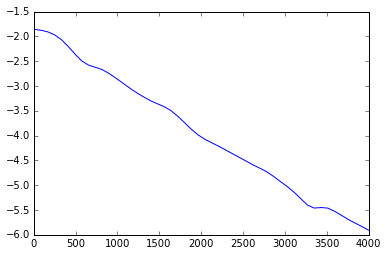

In [168]:
plt.plot(want_z,doneme)
print(doneme.shape)

In [143]:
radar = pyart.io.read('/data/xsapr_test_case/XNW130928080000.RAW1HDW')

In [234]:
rx, ry, rz  = (radar.gate_x['data'].flatten(), 
              radar.gate_y['data'].flatten(),
              radar.gate_z['data'].flatten())

In [235]:
que2 = np.array([[rz[i], ry[i], rx[i]] for i in range(len(rz))])

In [236]:
doneme2 = my_interpolating_function(que2)

In [237]:
my_new_field = doneme2.reshape(radar.fields['reflectivity']['data'].shape)
mnf_masked = np.ma.masked_where(my_new_field == radar.fields['reflectivity']['_FillValue'],
                                my_new_field)

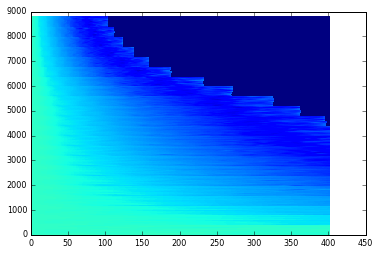

In [238]:
plt.pcolormesh(my_new_field, vmin = -10, vmax = 10)

In [239]:
radar.add_field_like('velocity', 'U', 
                     mnf_masked, 
                     replace_existing = True)

{-98.0: ([<matplotlib.lines.Line2D at 0x118556810>],
  [<matplotlib.text.Text at 0x10e570b50>]),
 -97.799999999999997: ([<matplotlib.lines.Line2D at 0x118556ed0>],
  [<matplotlib.text.Text at 0x10e9dc050>]),
 -97.599999999999994: ([<matplotlib.lines.Line2D at 0x10e55c4d0>],
  [<matplotlib.text.Text at 0x10e9dc490>]),
 -97.399999999999991: ([<matplotlib.lines.Line2D at 0x10e55ca90>],
  [<matplotlib.text.Text at 0x10e9dc8d0>]),
 -97.199999999999989: ([<matplotlib.lines.Line2D at 0x10e55cf90>],
  [<matplotlib.text.Text at 0x10e9dcd10>]),
 -96.999999999999986: ([<matplotlib.lines.Line2D at 0x10e570650>], [])}

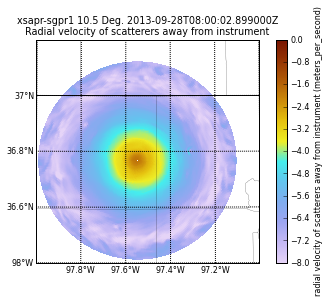

In [260]:
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('U', vmin = -8, vmax = 0, sweep =10, 
                     min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'i',cmap = pyart.graph.cm.LangRainbow12)
display.basemap.drawstates()
display.basemap.drawparallels(lat_lines, labels=[True,False,False,False])
display.basemap.drawcounties()
display.basemap.drawmeridians(lon_lines,labels=[True,False,False,True])


In [252]:
grids = pyart.map.grid_from_radars(
         (radar,), grid_shape=(36, 341, 341),
        grid_limits=((1, 8000.0),(-40000, 40000), (-40000, 40000)),
        gridding_algo="map_gates_to_grid",
        weighting_function='BARNES')

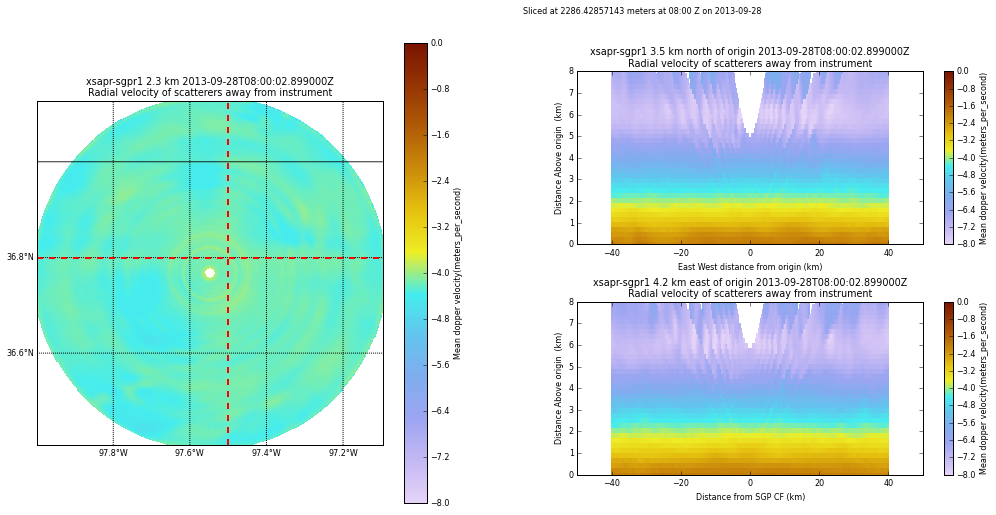

In [256]:
lon_lines = np.arange(-98, -95, .2)
lat_lines = np.arange(34, 37, .2)

display = pyart.graph.GridMapDisplay(grids)

# create the figure
font = {'size': 8}
matplotlib.rc('font', **font)
fig = plt.figure(figsize=[15, 8])

# panel sizes
map_panel_axes = [0.05, 0.05, .4, .80]
x_cut_panel_axes = [0.55, 0.10, .4, .30]
y_cut_panel_axes = [0.55, 0.50, .4, .30]
colorbar_panel_axes = [0.05, 0.90, .4, .03]

min_lon=-98.
max_lon=-97
min_lat=36.4
max_lat=37.2

# parameters
level = 10
vmin = -8
vmax = 0
lat = 36.8
lon = -97.5

# panel 1, basemap, radar reflectivity and NARR overlay
ax1 = fig.add_axes(map_panel_axes)
display.plot_basemap(lon_lines = lon_lines, lat_lines= lat_lines )
display.plot_grid('U', level=level, vmin=vmin, 
                  vmax=vmax, cmap = pyart.graph.cm.LangRainbow12)
display.plot_crosshairs(lon=lon, lat=lat)

# plot the reanalysis on the basemap
# colorbar
#cbax = fig.add_axes(colorbar_panel_axes)
#display.plot_colorbar(cax=cbax)

# panel 2, longitude slice.
ax2 = fig.add_axes(x_cut_panel_axes)
display.plot_longitude_slice('U', lon=lon, lat=lat, vmin=vmin, 
                             vmax=vmax, cmap = pyart.graph.cm.LangRainbow12)
ax2.set_xlabel('Distance from SGP CF (km)')
plt.ylim([0,8])
# panel 3, latitude slice
ax3 = fig.add_axes(y_cut_panel_axes)
display.plot_latitude_slice('U', lon=lon, lat=lat, 
                            vmin=vmin, vmax=vmax, cmap = pyart.graph.cm.LangRainbow12)
plt.ylim([0,8])
# add a title
slc_height = grids.axes['z_disp']['data'][level]
dts = num2date(grids.axes['time']['data'], grids.axes['time']['units'])
datestr = dts[0].strftime('%H:%M Z on %Y-%m-%d')
title = 'Sliced at ' + str(slc_height) + ' meters at ' + datestr
fig.text(0.5, 0.9, title)
plt.show()

